## American Sign Language Detection using YOLOv9

In [1]:
import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [2]:
dataset_dir = './datasets'
output_dir = './'

In [3]:
with open('data.yaml', 'r') as file:
    data = yaml.safe_load(file)

print(yaml.dump(data, default_style=False))

names:
- A
- B
- C
- D
- E
- F
- G
- H
- I
- J
- K
- L
- M
- N
- O
- P
- Q
- R
- S
- T
- U
- V
- W
- X
- Y
- Z
nc: 26
roboflow:
  license: Public Domain
  project: american-sign-language-letters
  url: https://universe.roboflow.com/david-lee-d0rhs/american-sign-language-letters/dataset/1
  version: 1
  workspace: david-lee-d0rhs
test: test
train: train
val: valid



In [4]:
train_dir = data['train']
val_dir = data['val']
test_dir = data['test']

In [5]:
def count_samples(dataset_dir, path):
    directory = os.path.join(dataset_dir, path)
    class_counts = {chr(i): 0 for i in range(ord('A'), ord('Z') + 1)}
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                class_name = file[0]
                if class_name in class_counts:
                    class_counts[class_name] += 1
    return class_counts

train_counts = count_samples(dataset_dir, train_dir)
val_counts = count_samples(dataset_dir, val_dir)
test_counts = count_samples(dataset_dir, test_dir)

In [6]:
def plot_class_distribution(class_counts, dataset_name, ax):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    ax.bar(classes, counts, color='skyblue')
    ax.set_title(f'Class Distribution in {dataset_name}')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of Samples')
    ax.tick_params(axis='x', rotation=45)

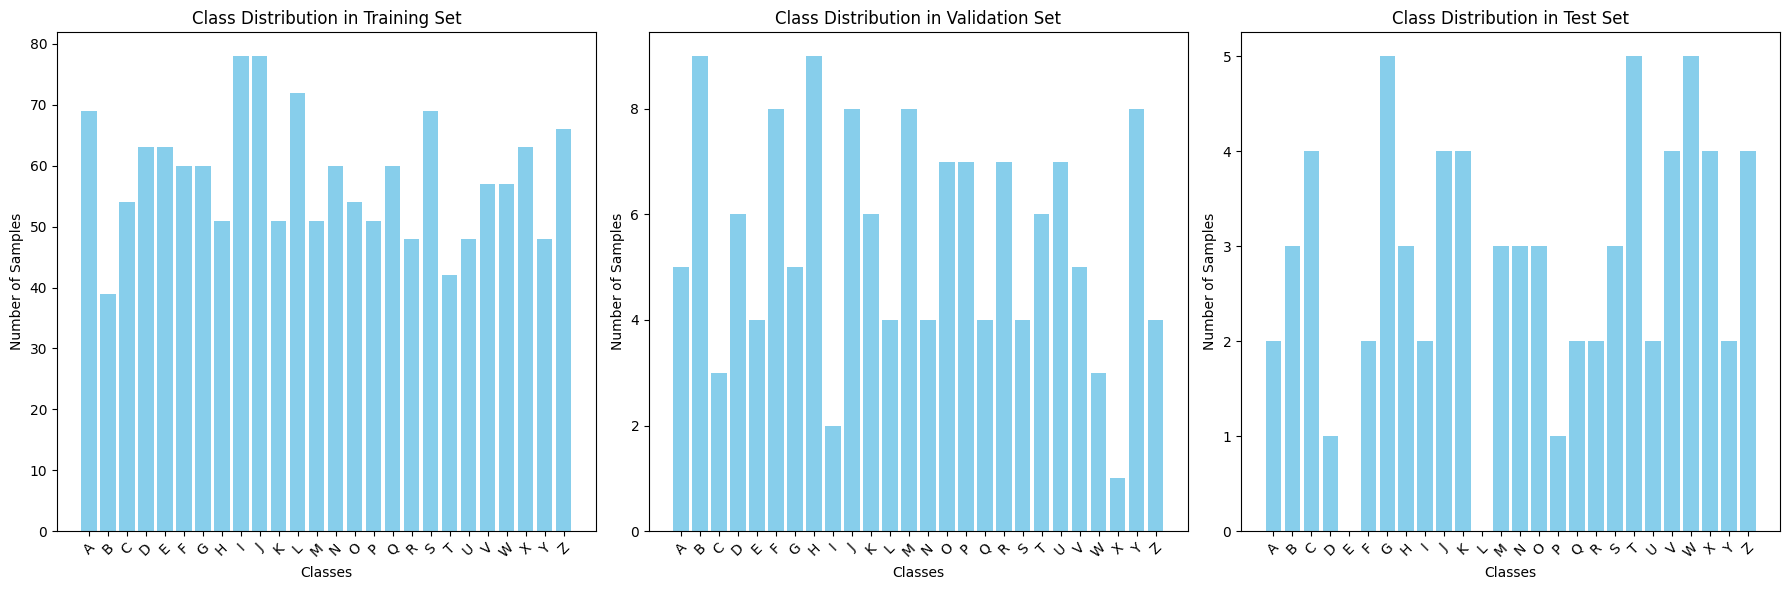

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

plot_class_distribution(train_counts, 'Training Set', ax1)
plot_class_distribution(val_counts, 'Validation Set', ax2)
plot_class_distribution(test_counts, 'Test Set', ax3)

plt.tight_layout()
plt.show()

In [8]:
def plot_sample_images(dataset_dir, path, class_counts):
    directory = os.path.join(dataset_dir, path)
    class_paths = {chr(i): [] for i in range(ord('A'), ord('Z') + 1)}
    
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                class_name = file[0]
                if class_name in class_paths:
                    file_path = os.path.join(root, file)
                    class_paths[class_name].append(file_path)
    
    num_classes = min(len(class_counts), 26)
    
    fig, axs = plt.subplots(2, 13, figsize=(30, 8))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    
    for i in range(num_classes):
        class_name = list(class_counts.keys())[i]
        paths = class_paths[class_name]
        if paths:
            chosen_path = random.choice(paths)
            img = Image.open(chosen_path)
            ax = axs[i // 13, i % 13]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(class_name, fontsize=42)
    
    plt.tight_layout()
    plt.show()

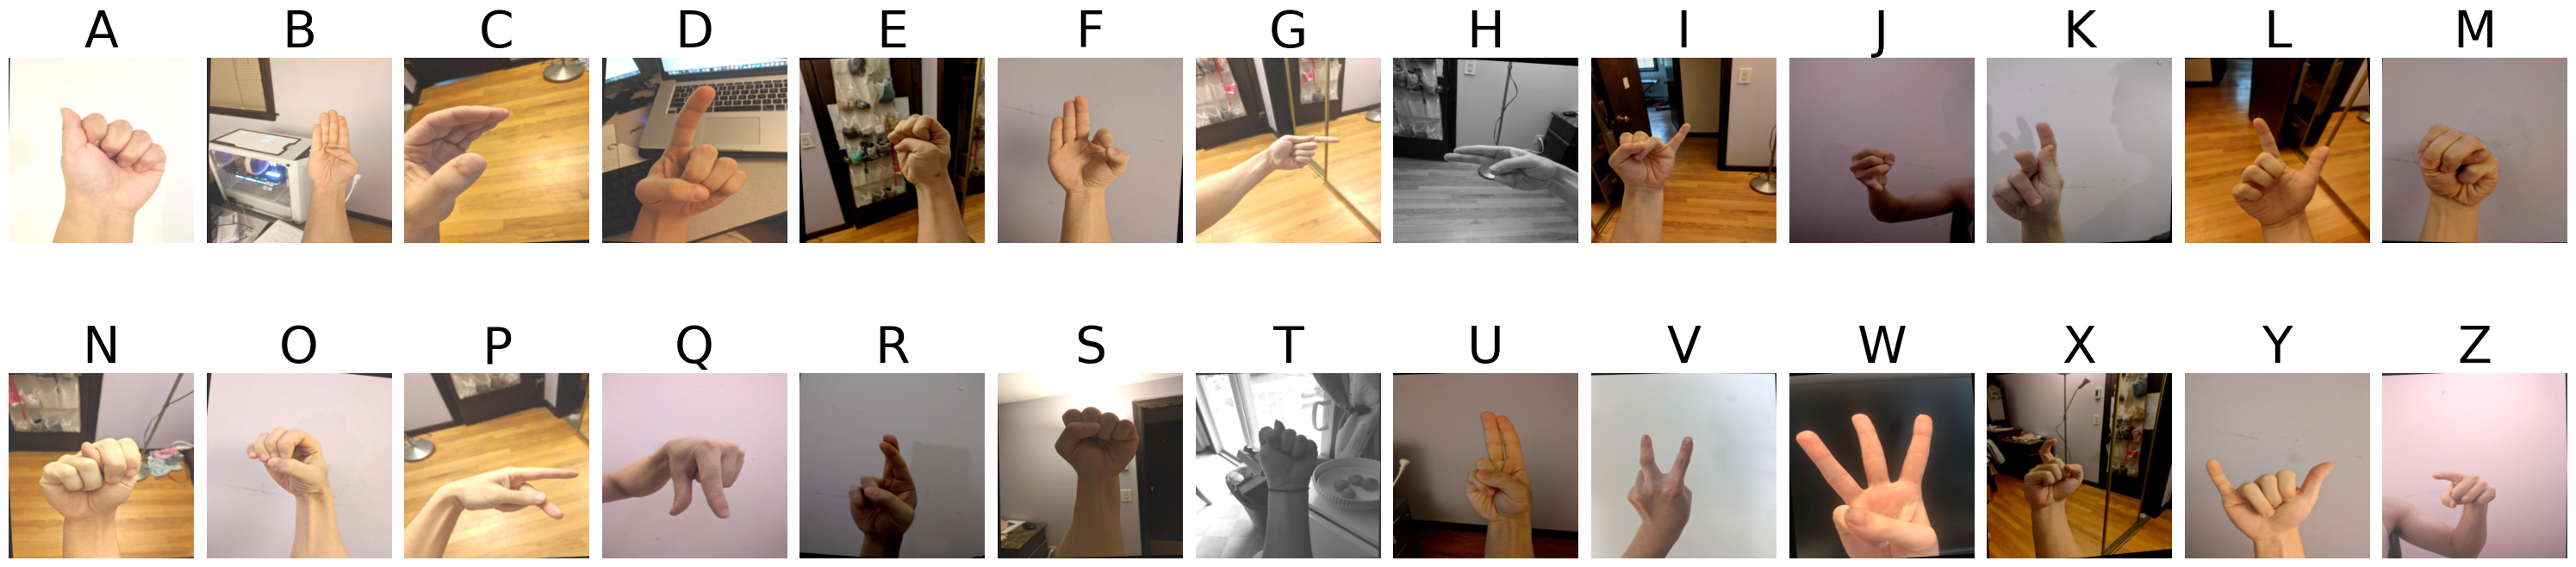

In [9]:
plot_sample_images(dataset_dir, train_dir, train_counts)

In [10]:
for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(dataset_dir, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}', end=" ")
            img_size = image.size
    print('\n')


Image sizes in train set:
(384, 384) (406, 406) (404, 404) (394, 394) (380, 380) (388, 388) (404, 404) (378, 378) (406, 406) (416, 416) (400, 400) (398, 398) (394, 394) (400, 400) (394, 394) (400, 400) (388, 388) (396, 396) (410, 410) (388, 388) (392, 392) (410, 410) (398, 398) (382, 382) (380, 380) (406, 406) (382, 382) (402, 402) (390, 390) (376, 376) (394, 394) (392, 392) (406, 406) (380, 380) (378, 378) (376, 376) (394, 394) (396, 396) (416, 416) (396, 396) (378, 378) (380, 380) (406, 406) (378, 378) (400, 400) (384, 384) (400, 400) (398, 398) (406, 406) (396, 396) (416, 416) (402, 402) (406, 406) (410, 410) (388, 388) (394, 394) (398, 398) (390, 390) (388, 388) (416, 416) (384, 384) (396, 396) (374, 374) (380, 380) (378, 378) (410, 410) (372, 372) (406, 406) (408, 408) (384, 384) (382, 382) (408, 408) (392, 392) (378, 378) (388, 388) (374, 374) (390, 390) (392, 392) (396, 396) (394, 394) (388, 388) (406, 406) (402, 402) (374, 374) (372, 372) (390, 390) (388, 388) (384, 384) (404,

In [11]:
height = 416
width = 416

In [12]:
model = YOLO('yolov9e.pt')

In [13]:
model.train(
    data = os.path.join(output_dir, 'data.yaml'),

    task = 'detect',

    imgsz = (height, width),

    epochs = 3,
    batch = 16,
    optimizer = 'auto',
    lr0 = 1e-3,
    lrf = 0.01,
    weight_decay = 5e-4,
    dropout = 0.0,
    fraction = 0.05,
    patience = 20,
    profile = False,
    label_smoothing = 0.0,
    seed = 88,
    
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    verbose = False
)

New https://pypi.org/project/ultralytics/8.2.38 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.34  Python-3.11.7 torch-2.3.1+cu118 CPU (AMD Ryzen 7 5700U with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov9e.pt, data=./data.yaml, epochs=3, time=None, patience=20, batch=16, imgsz=(416, 416), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.05, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, s

train: Scanning C:\Users\KIIT\Documents\GitHub\notebooks\YoloV9\datasets\train\labels.cache... 76 images, 0 backgrounds
val: Scanning C:\Users\KIIT\Documents\GitHub\notebooks\YoloV9\datasets\valid\labels.cache... 144 images, 0 backgrounds,


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000333, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      1.729      4.867      2.227         23        416: 100%|██████████| 5/5 [19:42<00:00, 236.4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [13:07<0

                   all        144        144    0.00344      0.584     0.0161    0.00749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G      1.362      2.779       1.82         26        416: 100%|██████████| 5/5 [21:45<00:00, 261.0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [09:47<0

                   all        144        144    0.00444      0.194     0.0163       0.01



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G      1.075       1.73        1.6         26        416: 100%|██████████| 5/5 [20:28<00:00, 245.7
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [10:37<0

                   all        144        144      0.544     0.0738      0.019     0.0119



3 epochs completed in 1.621 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 117.3MB
Optimizer stripped from runs\detect\train\weights\best.pt, 117.3MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.2.34  Python-3.11.7 torch-2.3.1+cu118 CPU (AMD Ryzen 7 5700U with Radeon Graphics)
YOLOv9e summary (fused): 687 layers, 57396446 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [09:58<0


                   all        144        144      0.544     0.0736     0.0188     0.0117
Speed: 5.7ms preprocess, 4125.9ms inference, 0.0ms loss, 12.1ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000011C3A8C6810>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0

In [14]:
model.export(
    format = 'onnx',
    imgsz = (height, width),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.2.34  Python-3.11.7 torch-2.3.1+cu118 CPU (AMD Ryzen 7 5700U with Radeon Graphics)
YOLOv9e summary (fused): 687 layers, 57396446 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from 'runs\detect\train\weights\best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 30, 3549) (111.8 MB)

ONNX: starting export with onnx 1.16.1 opset 17...
ONNX: export success  19.4s, saved as 'runs\detect\train\weights\best.onnx' (219.3 MB)

Export complete (33.0s)
Results saved to C:\Users\KIIT\Documents\GitHub\notebooks\YoloV9\runs\detect\train\weights
Predict:         yolo predict task=detect model=runs\detect\train\weights\best.onnx imgsz=416  
Validate:        yolo val task=detect model=runs\detect\train\weights\best.onnx imgsz=416 data=./data.yaml  
Visualize:       https://netron.app


'runs\\detect\\train\\weights\\best.onnx'

In [15]:
results_paths = [
    i for i in
    glob.glob(f'{output_dir}runs/detect/train/*.png') +
    glob.glob(f'{output_dir}runs/detect/train/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/train\\confusion_matrix.png',
 './runs/detect/train\\confusion_matrix_normalized.png',
 './runs/detect/train\\F1_curve.png',
 './runs/detect/train\\PR_curve.png',
 './runs/detect/train\\P_curve.png',
 './runs/detect/train\\results.png',
 './runs/detect/train\\R_curve.png',
 './runs/detect/train\\labels.jpg',
 './runs/detect/train\\labels_correlogram.jpg']

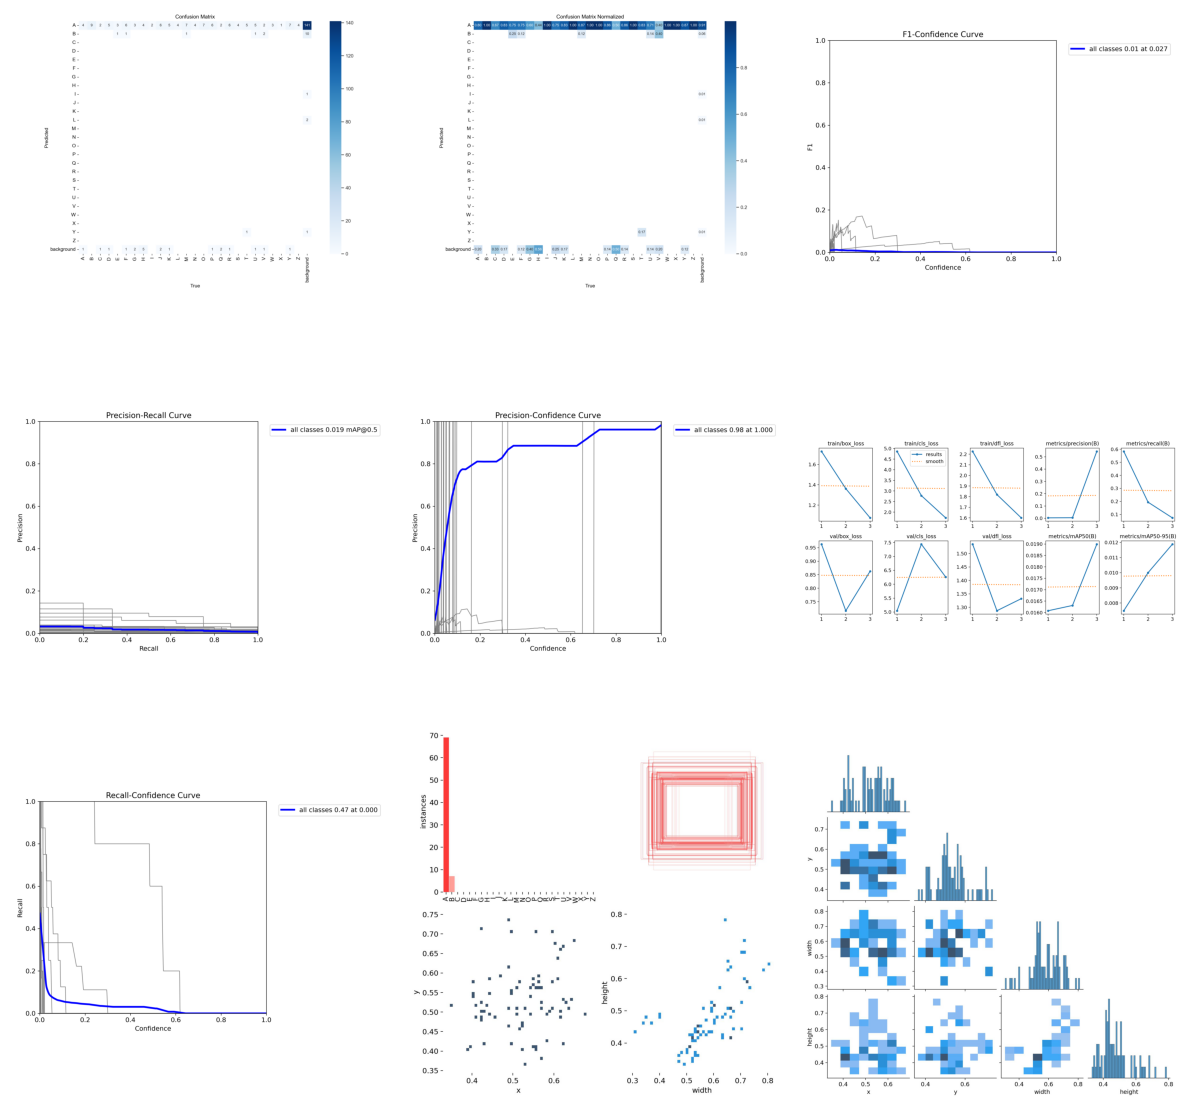

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, path in enumerate(results_paths):
    row = i // 3
    col = i % 3
    img = Image.open(path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.tight_layout()

plt.show()

In [17]:
df = pd.read_csv(f'{output_dir}/runs/detect/train/results.csv')
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.7286,4.8672,2.2266,0.00344,0.58387,0.01608,0.00749,0.96278,5.0465,1.5346,0.000013,0.000013,0.000013
1,2,1.3621,2.7789,1.8195,0.00444,0.19391,0.01631,0.01000,0.71672,7.4389,1.2872,0.000020,0.000020,0.000020
2,3,1.0747,1.7301,1.6000,0.54411,0.07377,0.01899,0.01188,0.86275,6.2618,1.3319,0.000016,0.000016,0.000016


In [18]:
validation_results_paths = [
    i for i in
    glob.glob(f'{output_dir}/runs/detect/train/*.png') +
    glob.glob(f'{output_dir}/runs/detect/train/*.jpg')
    if 'val_batch' in i
]

validation_results_paths

['.//runs/detect/train\\val_batch0_labels.jpg',
 './/runs/detect/train\\val_batch0_pred.jpg',
 './/runs/detect/train\\val_batch1_labels.jpg',
 './/runs/detect/train\\val_batch1_pred.jpg',
 './/runs/detect/train\\val_batch2_labels.jpg',
 './/runs/detect/train\\val_batch2_pred.jpg']

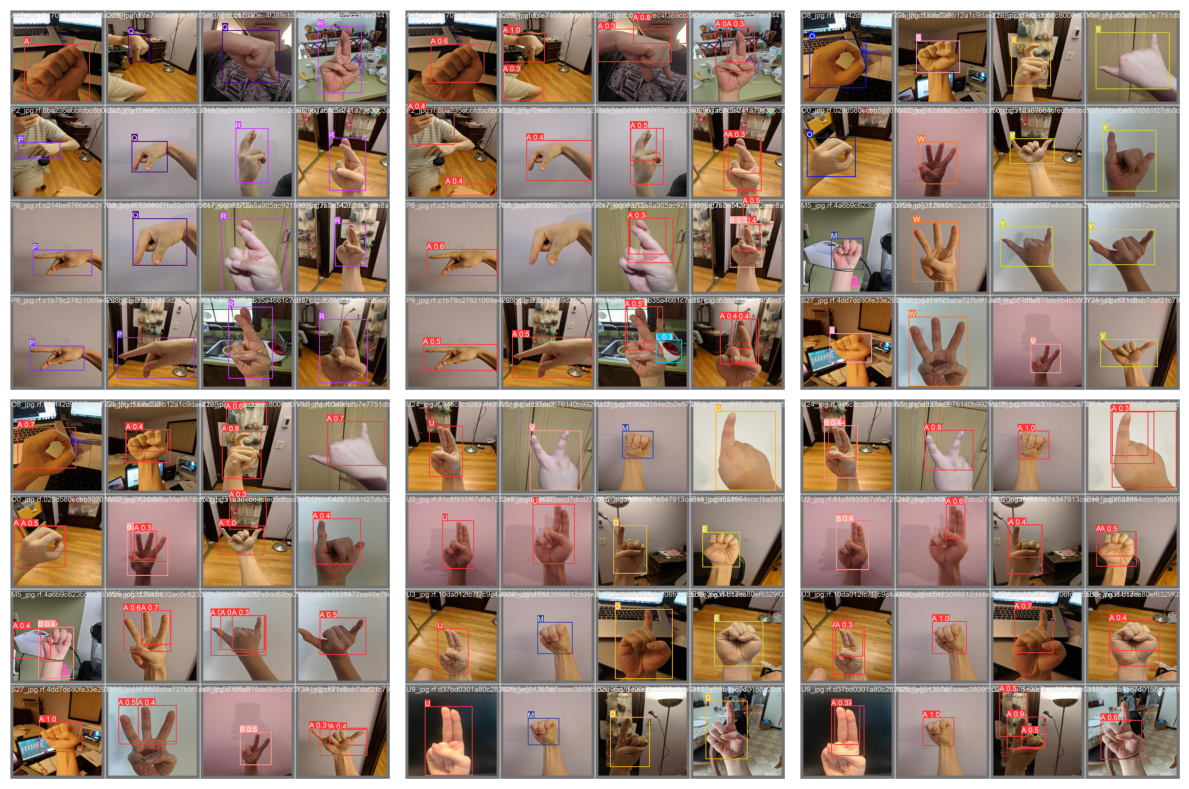

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, path in enumerate(validation_results_paths):
    row = i // 3
    col = i % 3
    img = Image.open(path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.tight_layout()

plt.show()